In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


# Turn off warnings
warnings.filterwarnings("ignore")

### Get NIFTY 50 historical data

In [56]:
# Define ticker and date rangticker = "BSE-500.BO"
start_date = "1980-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

ticker = '^NSEI'
# Download data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data = data[['Close']]
data

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,^NSEI
Date,
2007-09-17,4494.649902
2007-09-18,4546.200195
2007-09-19,4732.350098
2007-09-20,4747.549805
2007-09-21,4837.549805
...,...
2025-07-23,25219.900391
2025-07-24,25062.099609


In [57]:
yf_market_data = data['Close'].resample('ME').last()
yf_market_data

Ticker,^NSEI
Date,
2007-09-30,5021.350098
2007-10-31,5900.649902
2007-11-30,5762.750000
2007-12-31,6138.600098
2008-01-31,5137.450195
...,...
2025-03-31,23519.349609
2025-04-30,24334.199219
2025-05-31,24750.699219


In [58]:
nifty_historical = pd.read_csv("./data/NIFTY 50_Historical_PRICE.csv")
nifty_historical['Date'] = pd.to_datetime(nifty_historical['Date'])
nifty_historical = nifty_historical.set_index('Date').resample('ME').ffill()
nifty_historical = nifty_historical[:'2007-10-01']
nifty_historical  = pd.DataFrame(nifty_historical['Close'])
nifty_historical = nifty_historical.rename(columns = {'Close': '^NSEI'})

In [92]:
market_data = pd.concat([nifty_historical, yf_market_data], axis=0)
market_data.iloc[5:]

,^NSEI
Date,
1990-12-31,330.860000
1991-01-31,314.360000
1991-02-28,379.940000
1991-03-31,366.450000
1991-04-30,389.010000
...,...
2025-03-31,23519.349609
2025-04-30,24334.199219
2025-05-31,24750.699219


In [93]:
initial_value = 100

market_data['Return'] = market_data['^NSEI'].pct_change()
market_data['Portfolio'] = initial_value * (1 + market_data['Return']).cumprod()
market_data['Portfolio'].iloc[0] = initial_value

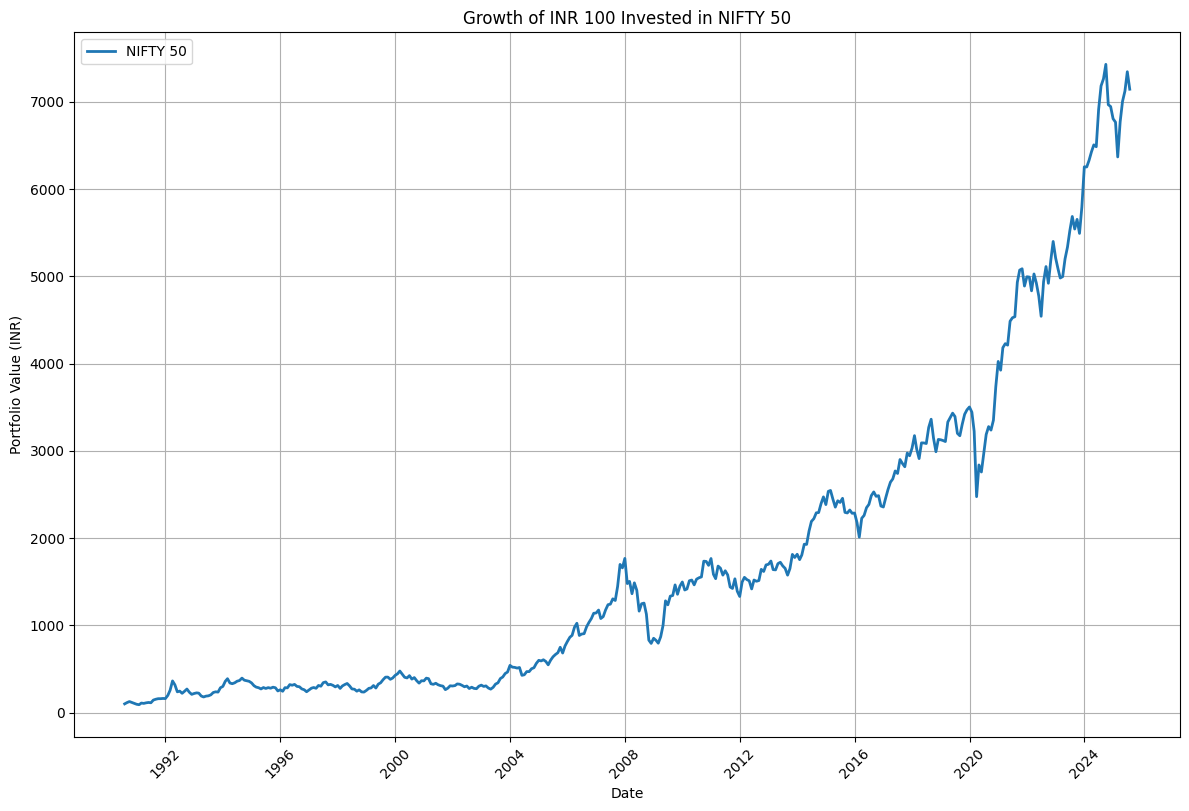

In [94]:
# Assuming 'portfolios' dictionary has the portfolios for each factor with 'Date' and 'Portfolio_Value'

# Step 1: Plotting the growth of portfolios for each factor
plt.figure(figsize=(12, 8))

# Plot the portfolio value over time
plt.plot(market_data.index, market_data['Portfolio'], label='NIFTY 50', linewidth = 2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.title('Growth of INR 100 Invested in NIFTY 50')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [95]:
market_data

,^NSEI,Return,Portfolio
Date,,,
1990-07-31,347.440000,NaN,100.000000
1990-08-31,400.060000,0.151451,115.145061
1990-09-30,439.720000,0.099135,126.559982
1990-10-31,403.660000,-0.082007,116.181211
1990-11-30,367.690000,-0.089110,105.828344
...,...,...,...
2025-03-31,23519.349609,0.063036,6769.326966
2025-04-30,24334.199219,0.034646,7003.856556
2025-05-31,24750.699219,0.017116,7123.733369


### Return distribution

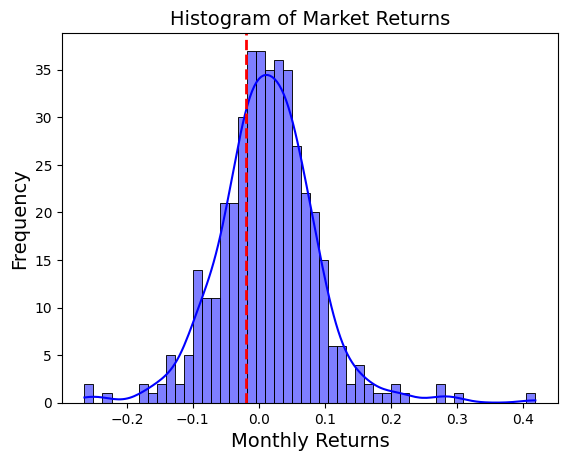

In [97]:
# Sample Data (Replace with your actual market_data DataFrame)
# market_data['Return'] should already contain daily returns
sns.histplot(market_data['Return'], bins=50, kde=True, color="blue")
plt.axvline(x=-0.02, color='red', linestyle='--', linewidth=2, label="Threshold (-0.02)")

# Set title and labels
plt.title("Histogram of Market Returns", fontsize=14)
plt.xlabel("Monthly Returns", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show plot
plt.show()


### Creating Price Momentum Features

In [98]:
market_data['next_month_return'] = market_data['Return'].shift(1)

In [99]:
windows = [1, 3, 6, 9, 12]

market_data['momentum_1_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(1)
market_data['momentum_3_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(3)
market_data['momentum_6_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(6)
market_data['momentum_9_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(9)
market_data['momentum_12_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(12)


market_data.head(13)

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1
Date,,,,,,,,,
1990-07-31,347.44,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,NaN,1.151451,NaN,NaN,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,0.151451,1.099135,NaN,NaN,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,0.099135,0.917993,1.161812,NaN,NaN,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.082007,0.910890,0.919087,NaN,NaN,NaN
1990-12-31,330.86,-0.100166,95.227953,-0.089110,0.899834,0.752433,NaN,NaN,NaN
1991-01-31,314.36,-0.049870,90.478932,-0.100166,0.950130,0.778774,0.904789,NaN,NaN
1991-02-28,379.94,0.208614,109.354133,-0.049870,1.208614,1.033316,0.949708,NaN,NaN
1991-03-31,366.45,-0.035506,105.471448,0.208614,0.964494,1.107568,0.833371,NaN,NaN


In [100]:
market_data.dropna(inplace=True)

### Training on 80% Data using Momentum Features

In [101]:
# Create the 'positive_returns' column
market_data['positive_returns'] = (market_data['next_month_return'] > -0.02).astype(int)

split_of_date_to_use = round(0.8*len(market_data))
# Features and target variable
X = market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[:split_of_date_to_use]
y = market_data['positive_returns'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.66666667 0.68181818 0.75757576 0.78461538 0.75384615]
Mean Accuracy: 0.7289
Standard Deviation: 0.0461


### Making Predictions on Training Data

In [102]:
market_data['market_regime'] = clf.predict(market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']])

In [103]:
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(market_data["positive_returns"], market_data["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)


          Predicted 0  Predicted 1
Actual 0          107           11
Actual 1           14          278


### Making Predictions on Test Data

In [104]:
test_data = market_data.iloc[split_of_date_to_use:]
test_data['market_regime'] = clf.predict(test_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']])

In [105]:
# Compute Confusion Matrix
cm = confusion_matrix(test_data["positive_returns"], test_data["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

          Predicted 0  Predicted 1
Actual 0           10           11
Actual 1            9           52


In [107]:
test_data.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime
Date,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,-0.058860,1.063036,0.994694,0.911220,0.979540,1.053409,0,0
2025-04-30,24334.199219,0.034646,7003.856556,0.063036,1.034646,1.035128,1.005323,0.975274,1.076503,1,1
2025-05-31,24750.699219,0.017116,7123.733369,0.034646,1.017116,1.118691,1.025676,0.980773,1.098532,1,1
2025-06-30,25517.050781,0.030963,7344.304277,0.017116,1.030963,1.084939,1.079182,0.988617,1.062741,1,1
2025-07-31,24821.099609,-0.027274,7143.995973,0.030963,0.972726,1.020009,1.055840,1.025439,0.994788,1,1


## Training on Full Data

In [108]:
X_final = market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[:-1]
y_final = market_data['positive_returns'].iloc[:-1]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X_final, y_final, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X_final, y_final)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.7195122  0.75609756 0.7804878  0.80487805 0.7654321 ]
Mean Accuracy: 0.7653
Standard Deviation: 0.0282


## Current Month Predicition

In [109]:
last_month = np.array(market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[-1]).reshape(1,-1)

final_prediction = clf.predict(last_month)
final_prediction[0]

np.int64(1)

### Adding consumption EPS as a feature

In [110]:
nifty_consumption_pe = pd.read_csv("./data/NIFTY INDIA CONSUMPTION_Historical.csv")
nifty_consumption_pe['Date'] = pd.to_datetime(nifty_consumption_pe['Date'])
nifty_consumption_pe = nifty_consumption_pe.set_index('Date').resample('ME').last()
nifty_consumption_pe.replace("-", pd.NA, inplace=True)  # Convert '-' to NaN
nifty_consumption_pe.fillna(method="ffill", inplace=True)  # Forward fill
nifty_consumption_pe

,IndexName,P/E,P/B,Div Yield %
Date,,,,
2011-07-31,NIFTY INDIA CONSUMPTION,24.09,4.38,1.42
2011-08-31,NIFTY INDIA CONSUMPTION,22.78,3.80,1.62
2011-09-30,NIFTY INDIA CONSUMPTION,22.32,3.68,1.64
2011-10-31,NIFTY INDIA CONSUMPTION,23.53,3.91,1.55
2011-11-30,NIFTY INDIA CONSUMPTION,21.90,3.64,1.64
...,...,...,...,...
2024-10-31,NIFTY INDIA CONSUMPTION,47.06,9.00,0.94
2024-11-30,NIFTY INDIA CONSUMPTION,46.63,8.97,0.95
2024-12-31,NIFTY INDIA CONSUMPTION,46.77,9.02,0.94


In [111]:
ticker_consumption = '^CNXCONSUM'
# Download data
data_consumption = yf.download(ticker_consumption, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data_consumption = data_consumption[['Close']]
data_consumption = data_consumption.resample('ME').last()

[*********************100%***********************]  1 of 1 completed

In [112]:
data_consumption['Close'].head()

Ticker,^CNXCONSUM
Date,
2011-07-31,1896.430054
2011-08-31,1807.989990
2011-09-30,1787.040039
2011-10-31,1898.369995
2011-11-30,1799.530029


In [113]:
nifty_consumption_pe['P/E'] = nifty_consumption_pe['P/E'].replace('-', '0').astype(float)
consumption_data_merged = pd.merge(data_consumption['Close'], nifty_consumption_pe, left_index= True, right_index=True)

In [114]:
consumption_data_merged['EPS'] = consumption_data_merged['^CNXCONSUM']/consumption_data_merged['P/E']
consumption_data_merged.loc[consumption_data_merged['EPS'] == np.float64('inf')]['EPS'] = 0

In [115]:
training_data_with_eps = pd.merge(market_data,consumption_data_merged['EPS'], left_index=True, right_index=True, how='left')
training_data_with_eps.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS
Date,,,,,,,,,,,,
1991-07-31,498.71,0.272349,143.538453,-0.027829,1.272349,1.281998,1.586430,1.235470,1.435385,0,0,NaN
1991-08-31,531.97,0.066692,153.111329,0.272349,1.066692,1.319435,1.400142,1.446789,1.329726,1,1,NaN
1991-09-30,553.79,0.041017,159.391550,0.066692,1.041017,1.412874,1.511229,1.673790,1.259415,1,1,NaN
1991-10-31,554.40,0.001102,159.567120,0.041017,1.001102,1.111668,1.425156,1.763583,1.373433,1,1,NaN
1991-11-30,563.17,0.015819,162.091296,0.001102,1.015819,1.058650,1.396820,1.482260,1.531644,1,1,NaN


### Adding CAPE as a feature

In [116]:
cape = pd.read_csv("./data/india_cape.csv")
cape['Date'] = pd.to_datetime(cape['Date'])
cape = cape.set_index('Date').resample('ME').last()
cape.head()

,BSE Sensex CAPE 10,BSE Sensex CAPE 7,BSE Sensex CAPE 5,NIFTY 500 CAPE 10,NIFTY 500 CAPE 7,NIFTY 500 CAPE 5
Date,,,,,,
1995-04-30,NaN,NaN,35.67,NaN,NaN,NaN
1995-05-31,NaN,NaN,33.25,NaN,NaN,NaN
1995-06-30,NaN,NaN,33.69,NaN,NaN,NaN
1995-07-31,NaN,NaN,32.58,NaN,NaN,NaN
1995-08-31,NaN,NaN,32.55,NaN,NaN,NaN


In [117]:
sheet_id = "1ZcT4v4PzjwACcbzmwYXGwxLMRXtuQGwsSEPyONMcfcU"
sheet_name = "Sheet1"  # or your specific sheet name

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

cape = pd.read_csv(url)
cape['Date'] = pd.to_datetime(cape['Date'])
cape = cape.set_index('Date').resample('ME').last()
cape.tail()

,BSE Sensex CAPE 5,Sensex Close Price,P/E,EPS,Inflation Rate,Inflation Adjusted EPS,Inflation Adjusted Price,Last 120 Month EPS Inflation Adj
Date,,,,,,,,
2025-02-28,31.12,73198.10,21.36,3426.877341,0.0394,3296.976468,70423.41736,2262.755115
2025-03-31,32.43,77414.92,21.58,3587.345690,0.0394,3451.362027,74480.39253,2296.541679
2025-04-30,33.33,80242.00,21.59,3716.628069,0.0340,3594.417861,77603.48162,2328.540286
2025-05-31,33.45,81451.00,22.68,3591.313933,0.0316,3481.304704,78955.99069,2360.428143
2025-06-30,33.93,83606.46,23.11,3617.761142,0.0293,3514.778143,81226.52288,2393.902282


In [119]:
training_data_with_eps_and_cape = pd.merge(training_data_with_eps,cape['BSE Sensex CAPE 5'], left_index=True, right_index=True, how='left')
training_data_with_eps_and_cape.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5
Date,,,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,-0.058860,1.063036,0.994694,0.911220,0.979540,1.053409,0,0,NaN,32.43
2025-04-30,24334.199219,0.034646,7003.856556,0.063036,1.034646,1.035128,1.005323,0.975274,1.076503,1,1,NaN,33.33
2025-05-31,24750.699219,0.017116,7123.733369,0.034646,1.017116,1.118691,1.025676,0.980773,1.098532,1,1,NaN,33.45
2025-06-30,25517.050781,0.030963,7344.304277,0.017116,1.030963,1.084939,1.079182,0.988617,1.062741,1,1,NaN,33.93
2025-07-31,24821.099609,-0.027274,7143.995973,0.030963,0.972726,1.020009,1.055840,1.025439,0.994788,1,1,NaN,NaN


In [120]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + '_CAPE'
    training_data_with_eps_and_cape[column_name] = training_data_with_eps_and_cape['BSE Sensex CAPE 5'] / training_data_with_eps_and_cape['BSE Sensex CAPE 5'].shift(window)

training_data_with_eps_and_cape.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE
Date,,,,,,,,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,-0.058860,1.063036,0.994694,0.911220,0.979540,1.053409,0,0,NaN,32.43,1.042095,1.017252,0.945481,0.979462,0.983025
2025-04-30,24334.199219,0.034646,7003.856556,0.063036,1.034646,1.035128,1.005323,0.975274,1.076503,1,1,NaN,33.33,1.027752,1.102183,1.017710,0.980583,1.011533
2025-05-31,24750.699219,0.017116,7123.733369,0.034646,1.017116,1.118691,1.025676,0.980773,1.098532,1,1,NaN,33.45,1.003600,1.074871,1.059215,0.993466,1.027966
2025-06-30,25517.050781,0.030963,7344.304277,0.017116,1.030963,1.084939,1.079182,0.988617,1.062741,1,1,NaN,33.93,1.014350,1.046253,1.064304,0.989213,1.024766
2025-07-31,24821.099609,-0.027274,7143.995973,0.030963,0.972726,1.020009,1.055840,1.025439,0.994788,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Addding Forex - Dollar to INR as a feature

In [121]:
fred_data = pd.read_csv("./data/USD_INR.csv")
fred_data['Date'] = pd.to_datetime(fred_data['Date'], format='%d-%m-%Y')
fred_data = fred_data.set_index('Date').resample('ME').last()
fred_data = fred_data[:'2003-11-30']
fred_data  = pd.DataFrame(fred_data['USD/INR'])
fred_data = fred_data.rename(columns = {'USD/INR': 'USDINR=X'})
fred_data.tail()

,USDINR=X
Date,
2003-07-31,46.15
2003-08-31,45.88
2003-09-30,45.78
2003-10-31,45.33
2003-11-30,45.82


In [122]:
ticker = 'USDINR=X'
# Download data
usd_inr = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
usd_inr = usd_inr[['Close']]
usd_inr = usd_inr.resample('ME').last()

usd_inr = pd.concat([fred_data,usd_inr['Close']], axis=0)
usd_inr.tail()

[*********************100%***********************]  1 of 1 completed


,USDINR=X
Date,
2025-03-31,85.538803
2025-04-30,85.170799
2025-05-31,85.361298
2025-06-30,85.455299
2025-07-31,86.777603


In [124]:
training_data_with_eps_and_cape_and_usdinr = pd.merge(training_data_with_eps_and_cape, usd_inr['USDINR=X'], left_index=True, right_index=True, how='left')
training_data_with_eps_and_cape_and_usdinr.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,USDINR=X
Date,,,,,,,,,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,-0.058860,1.063036,0.994694,0.911220,0.979540,1.053409,0,0,NaN,32.43,1.042095,1.017252,0.945481,0.979462,0.983025,85.538803
2025-04-30,24334.199219,0.034646,7003.856556,0.063036,1.034646,1.035128,1.005323,0.975274,1.076503,1,1,NaN,33.33,1.027752,1.102183,1.017710,0.980583,1.011533,85.170799
2025-05-31,24750.699219,0.017116,7123.733369,0.034646,1.017116,1.118691,1.025676,0.980773,1.098532,1,1,NaN,33.45,1.003600,1.074871,1.059215,0.993466,1.027966,85.361298
2025-06-30,25517.050781,0.030963,7344.304277,0.017116,1.030963,1.084939,1.079182,0.988617,1.062741,1,1,NaN,33.93,1.014350,1.046253,1.064304,0.989213,1.024766,85.455299
2025-07-31,24821.099609,-0.027274,7143.995973,0.030963,0.972726,1.020009,1.055840,1.025439,0.994788,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.777603


## Processing training data

Creating momentum features for USD INR

In [126]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + '_USDINR'
    training_data_with_eps_and_cape_and_usdinr[column_name] = training_data_with_eps_and_cape_and_usdinr['USDINR=X'] / training_data_with_eps_and_cape_and_usdinr['USDINR=X'].shift(window)

training_data_with_eps_and_cape_and_usdinr.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,...,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,USDINR=X,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,-0.058860,1.063036,0.994694,0.911220,0.979540,1.053409,0,...,1.017252,0.945481,0.979462,0.983025,85.538803,0.979523,0.997111,1.021769,1.025020,1.025731
2025-04-30,24334.199219,0.034646,7003.856556,0.063036,1.034646,1.035128,1.005323,0.975274,1.076503,1,...,1.102183,1.017710,0.980583,1.011533,85.170799,0.995698,0.982963,1.012864,1.017098,1.020607
2025-05-31,24750.699219,0.017116,7123.733369,0.034646,1.017116,1.118691,1.025676,0.980773,1.098532,1,...,1.074871,1.059215,0.993466,1.027966,85.361298,1.002237,0.977490,1.010532,1.017477,1.024488
2025-06-30,25517.050781,0.030963,7344.304277,0.017116,1.030963,1.084939,1.079182,0.988617,1.062741,1,...,1.046253,1.064304,0.989213,1.024766,85.455299,1.001101,0.999024,0.996138,1.020771,1.024019
2025-07-31,24821.099609,-0.027274,7143.995973,0.030963,0.972726,1.020009,1.055840,1.025439,0.994788,1,...,NaN,NaN,NaN,NaN,86.777603,1.015474,1.018866,1.001507,1.031972,1.036287


momentum features for consumotion EPS

In [127]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + 'consumption_eps'
    training_data_with_eps_and_cape_and_usdinr[column_name] = training_data_with_eps_and_cape_and_usdinr['EPS'] / training_data_with_eps_and_cape_and_usdinr['EPS'].shift(window)

training_data_with_eps_and_cape_and_usdinr.tail()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,...,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1consumption_eps,momentum_3consumption_eps,momentum_6consumption_eps,momentum_9consumption_eps,momentum_12consumption_eps
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-31,23519.349609,0.063036,6769.326966,-0.058860,1.063036,0.994694,0.911220,0.979540,1.053409,0,...,0.979523,0.997111,1.021769,1.025020,1.025731,NaN,NaN,NaN,NaN,NaN
2025-04-30,24334.199219,0.034646,7003.856556,0.063036,1.034646,1.035128,1.005323,0.975274,1.076503,1,...,0.995698,0.982963,1.012864,1.017098,1.020607,NaN,NaN,NaN,NaN,NaN
2025-05-31,24750.699219,0.017116,7123.733369,0.034646,1.017116,1.118691,1.025676,0.980773,1.098532,1,...,1.002237,0.977490,1.010532,1.017477,1.024488,NaN,NaN,NaN,NaN,NaN
2025-06-30,25517.050781,0.030963,7344.304277,0.017116,1.030963,1.084939,1.079182,0.988617,1.062741,1,...,1.001101,0.999024,0.996138,1.020771,1.024019,NaN,NaN,NaN,NaN,NaN
2025-07-31,24821.099609,-0.027274,7143.995973,0.030963,0.972726,1.020009,1.055840,1.025439,0.994788,1,...,1.015474,1.018866,1.001507,1.031972,1.036287,NaN,NaN,NaN,NaN,NaN


In [128]:
training_data_final = training_data_with_eps_and_cape_and_usdinr[['momentum_1_1',
       'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1','BSE Sensex CAPE 5','momentum_1_USDINR', 'momentum_3_USDINR',
       'momentum_6_USDINR', 'momentum_9_USDINR', 'momentum_12_USDINR', 'momentum_1_CAPE','momentum_3_CAPE','momentum_6_CAPE','momentum_9_CAPE','momentum_12_CAPE', 'positive_returns', 'next_month_return']]

training_data_final.tail()

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return
Date,,,,,,,,,,,,,,,,,,
2025-03-31,1.063036,0.994694,0.911220,0.979540,1.053409,32.43,0.979523,0.997111,1.021769,1.025020,1.025731,1.042095,1.017252,0.945481,0.979462,0.983025,0,-0.058860
2025-04-30,1.034646,1.035128,1.005323,0.975274,1.076503,33.33,0.995698,0.982963,1.012864,1.017098,1.020607,1.027752,1.102183,1.017710,0.980583,1.011533,1,0.063036
2025-05-31,1.017116,1.118691,1.025676,0.980773,1.098532,33.45,1.002237,0.977490,1.010532,1.017477,1.024488,1.003600,1.074871,1.059215,0.993466,1.027966,1,0.034646
2025-06-30,1.030963,1.084939,1.079182,0.988617,1.062741,33.93,1.001101,0.999024,0.996138,1.020771,1.024019,1.014350,1.046253,1.064304,0.989213,1.024766,1,0.017116
2025-07-31,0.972726,1.020009,1.055840,1.025439,0.994788,NaN,1.015474,1.018866,1.001507,1.031972,1.036287,NaN,NaN,NaN,NaN,NaN,1,0.030963


In [156]:
training_data_final = training_data_final.dropna()
training_data_final

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return
Date,,,,,,,,,,,,,,,,,,
1996-04-30,1.130985,1.313453,1.127598,1.120805,1.183186,29.83,1.018923,0.959956,1.020408,1.113586,1.112878,1.050352,1.124811,0.921248,0.915592,0.836277,1,-0.007264
1996-05-31,0.978068,1.098145,1.264262,1.121617,1.092761,30.13,1.006571,1.010904,1.009166,1.105428,1.120904,1.010057,1.012433,1.056081,0.925653,0.906165,1,0.130985
1996-06-30,1.029433,1.138739,1.234962,1.108805,1.167254,30.67,1.005677,1.031441,1.007106,1.043901,1.127985,1.017922,1.079930,1.116491,0.964162,0.910359,0,-0.021932
1996-07-31,0.929421,0.935793,1.229120,1.055198,1.048841,27.89,1.007621,1.020000,0.979155,1.040816,1.135857,0.909358,0.934965,1.051659,0.861334,0.856047,1,0.029433
1996-08-31,0.986757,0.944106,1.036765,1.193597,1.058925,25.64,1.004202,1.017599,1.028694,1.026926,1.124882,0.919326,0.850979,0.861559,0.898703,0.787711,0,-0.070579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.941140,0.916854,0.876715,0.981980,1.006455,31.12,1.007848,1.033803,1.040907,1.048080,1.053250,1.029101,0.985434,0.924265,0.956361,0.950519,1,-0.005769
2025-03-31,1.063036,0.994694,0.911220,0.979540,1.053409,32.43,0.979523,0.997111,1.021769,1.025020,1.025731,1.042095,1.017252,0.945481,0.979462,0.983025,0,-0.058860
2025-04-30,1.034646,1.035128,1.005323,0.975274,1.076503,33.33,0.995698,0.982963,1.012864,1.017098,1.020607,1.027752,1.102183,1.017710,0.980583,1.011533,1,0.063036


In [130]:
training_data_final.columns

Index(['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1',
       'momentum_12_1', 'BSE Sensex CAPE 5', 'momentum_1_USDINR',
       'momentum_3_USDINR', 'momentum_6_USDINR', 'momentum_9_USDINR',
       'momentum_12_USDINR', 'momentum_1_CAPE', 'momentum_3_CAPE',
       'momentum_6_CAPE', 'momentum_9_CAPE', 'momentum_12_CAPE',
       'positive_returns', 'next_month_return'],
      dtype='object')

In [131]:
training_columns = [
       'momentum_3_1', 'momentum_6_1','momentum_3_USDINR',
       'momentum_6_USDINR', 'momentum_1_CAPE','momentum_3_CAPE']

# training_columns = [
#        'momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1',
#        'momentum_12_1', 'BSE Sensex CAPE 5', 'momentum_1_USDINR',
#        'momentum_3_USDINR', 'momentum_6_USDINR', 'momentum_9_USDINR',
#        'momentum_12_USDINR']



## Training random forest model 

In [159]:
training_data_final

split_of_date_to_use = round(0.75*len(training_data_final))
# Features and target variable
X = training_data_final[training_columns].iloc[:split_of_date_to_use]
y = training_data_final['positive_returns'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.67924528 0.77358491 0.73584906 0.64150943 0.73076923]
Mean Accuracy: 0.7122
Standard Deviation: 0.0464


In [160]:
X

,momentum_3_1,momentum_6_1,momentum_3_USDINR,momentum_6_USDINR,momentum_1_CAPE,momentum_3_CAPE
Date,,,,,,
1996-04-30,1.313453,1.127598,0.959956,1.020408,1.050352,1.124811
1996-05-31,1.098145,1.264262,1.010904,1.009166,1.010057,1.012433
1996-06-30,1.138739,1.234962,1.031441,1.007106,1.017922,1.079930
1996-07-31,0.935793,1.229120,1.020000,0.979155,0.909358,0.934965
1996-08-31,0.944106,1.036765,1.017599,1.028694,0.919326,0.850979
...,...,...,...,...,...,...
2017-10-31,1.025622,1.110839,1.011211,1.012214,1.009914,1.011282
2017-11-30,1.031120,1.062913,1.006856,0.996846,1.028112,1.043006
2017-12-31,1.075813,1.106061,0.980141,0.988838,1.009115,1.047769


### Prediction on test data

In [133]:
from sklearn.metrics import accuracy_score

test_data_final = training_data_final.iloc[split_of_date_to_use:]
test_data_final['market_regime'] = clf.predict(test_data_final[training_columns])

# Compute Confusion Matrix
cm = confusion_matrix(test_data_final["positive_returns"], test_data_final["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

acc_score = accuracy_score(test_data_final["positive_returns"], test_data_final["market_regime"])
print(f"Accuracy: {acc_score*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0           12           11
Actual 1            7           58
Accuracy: 79.55%


In [134]:
test_data_final

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1_CAPE,momentum_3_CAPE,momentum_6_CAPE,momentum_9_CAPE,momentum_12_CAPE,positive_returns,next_month_return,market_regime
Date,,,,,,,,,,,,,,,,,,,
2018-03-31,0.963866,0.960401,1.033212,1.062263,1.102461,23.15,1.001849,1.015110,0.994951,1.003780,1.003704,0.971872,0.995699,1.043263,1.050363,1.098197,0,-0.048501,1
2018-04-30,1.061862,0.973852,1.039094,1.065718,1.154266,23.63,1.024297,1.044537,1.027260,1.038777,1.039806,1.020734,0.976850,1.054440,1.066336,1.112524,0,-0.036134,1
2018-05-31,0.999702,1.023187,1.049831,1.082502,1.115879,24.18,1.012310,1.038823,1.046809,1.053986,1.043508,1.023275,1.015113,1.049479,1.094613,1.115314,1,0.061862,1
2018-06-30,0.997965,1.059385,1.017435,1.094569,1.125345,24.23,1.020268,1.057923,1.073908,1.052581,1.061922,1.002068,1.046652,1.042151,1.091933,1.099365,1,-0.000298,1
2018-07-31,1.059939,1.057466,1.029816,1.098807,1.126961,24.05,0.998376,1.031151,1.077075,1.059261,1.071136,0.992571,1.017774,0.994212,1.073182,1.085289,1,-0.002035,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.941140,0.916854,0.876715,0.981980,1.006455,31.12,1.007848,1.033803,1.040907,1.048080,1.053250,1.029101,0.985434,0.924265,0.956361,0.950519,1,-0.005769,1
2025-03-31,1.063036,0.994694,0.911220,0.979540,1.053409,32.43,0.979523,0.997111,1.021769,1.025020,1.025731,1.042095,1.017252,0.945481,0.979462,0.983025,0,-0.058860,1
2025-04-30,1.034646,1.035128,1.005323,0.975274,1.076503,33.33,0.995698,0.982963,1.012864,1.017098,1.020607,1.027752,1.102183,1.017710,0.980583,1.011533,1,0.063036,1


## Making next month prediciton using the final Model

In [135]:
X = training_data_final[training_columns][:-1]
y = training_data_final['positive_returns'][:-1]

print(X.tail())

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

            momentum_3_1  momentum_6_1  momentum_3_USDINR  momentum_6_USDINR  \
Date                                                                           
2025-01-31      0.971207      0.942177           1.030419           1.034727   
2025-02-28      0.916854      0.876715           1.033803           1.040907   
2025-03-31      0.994694      0.911220           0.997111           1.021769   
2025-04-30      1.035128      1.005323           0.982963           1.012864   
2025-05-31      1.118691      1.025676           0.977490           1.010532   

            momentum_1_CAPE  momentum_3_CAPE  
Date                                          
2025-01-31         0.948557         0.923359  
2025-02-28         1.029101         0.985434  
2025-03-31         1.042095         1.017252  
2025-04-30         1.027752         1.102183  
2025-05-31         1.003600         1.074871  
Cross-Validation Scores: [0.71830986 0.72857143 0.72857143 0.77142857 0.75714286]
Mean Accuracy: 0.7408
Standa

In [136]:
from sklearn.metrics import accuracy_score

test_data_final = training_data_final.iloc[-1:]
test_data_final['market_regime'] = clf.predict(test_data_final[training_columns])
test_data_final['market_regime']

Date
2025-06-30    1
Name: market_regime, dtype: int64

In [194]:
# Download NIFTYBEES historical data
niftybees_ticker = 'NIFTYBEES.NS'
niftybees_data = yf.download(niftybees_ticker, start=start_date, end=end_date, interval="1d")
niftybees_data = niftybees_data[['Close']].resample('ME').last()
niftybees_data = niftybees_data.rename(columns={'Close': 'NIFTYBEES'})['NIFTYBEES']
# display(niftybees_data)


# Merge with predictor data
strategy_data = pd.merge(training_data_final, niftybees_data, left_index=True, right_index=True, how='inner')
# display(strategy_data.tail())

# Prepare to store strategy returns and predictions
strategy_returns = []
strategy_predictions = []
actual_returns = []
dates = []

risk_free_rate = 0.06 / 12  # Monthly risk-free rate

for i in range(len(strategy_data) - 1):
    # Train RF on all data up to current month
    X_train = strategy_data[training_columns].iloc[:i+1]
    y_train = strategy_data['positive_returns'].iloc[:i+1]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict for next month
    X_next = strategy_data[training_columns].iloc[i+1].values.reshape(1, -1)
    pred = clf.predict(X_next)[0]
    strategy_predictions.append(pred)
    
    # Calculate next month's return for NIFTYBEES
    ret = (strategy_data['NIFTYBEES.NS'].iloc[i+1] - strategy_data['NIFTYBEES.NS'].iloc[i]) / strategy_data['NIFTYBEES.NS'].iloc[i]
    actual_returns.append(ret)
    
    # Long if pred==1, short if pred==0
    strat_ret = ret if pred == 1 else -ret
    strategy_returns.append(strat_ret)
    dates.append(strategy_data.index[i+1])

# Convert to DataFrame
results_df = pd.DataFrame({
    'Date': dates,
    'Prediction': strategy_predictions,
    'NIFTYBEES_Return': actual_returns,
    'Strategy_Return': strategy_returns
}).set_index('Date')

# Performance metrics
excess_returns_niftybees = np.array(strategy_returns) - risk_free_rate
sharpe_niftybees = np.mean(excess_returns_niftybees) / np.std(strategy_returns) * np.sqrt(12)
cum_returns_niftybees = (1 + np.array(strategy_returns)).cumprod()
max_drawdown_niftybees = np.max((np.maximum.accumulate(cum_returns_niftybees) - cum_returns_niftybees) / np.maximum.accumulate(cum_returns_niftybees))
annualized_return_niftybees = (cum_returns_niftybees[-1]) ** (12 / len(cum_returns_niftybees)) - 1
hit_ratio_niftybees = np.mean((np.sign(strategy_returns) == 1).astype(int))

# print(max_drawdown_niftybees)

print(f"Sharpe Ratio: {sharpe_niftybees:.2f}")
print(f"Max Drawdown: {max_drawdown_niftybees:.2%}")
print(f"Annualized Return: {annualized_return_niftybees:.2%}")
print(f"Hit Ratio: {hit_ratio_niftybees:.2%}")

results_df.tail()

[*********************100%***********************]  1 of 1 completed



Sharpe Ratio: 0.84
Max Drawdown: 21.94%
Annualized Return: 20.77%
Hit Ratio: 66.50%


,Prediction,NIFTYBEES_Return,Strategy_Return
Date,,,
2025-02-28,0,-0.055323,0.055323
2025-03-31,1,0.059408,0.059408
2025-04-30,1,0.033357,0.033357
2025-05-31,1,0.021986,0.021986
2025-06-30,1,0.030723,0.030723


In [195]:
# Download GOLDBEES historical data
goldbees_ticker = 'GOLDBEES.NS'
goldbees_data = yf.download(goldbees_ticker, start=start_date, end=end_date, interval="1d")
goldbees_data = goldbees_data[['Close']].resample('ME').last()
goldbees_data = goldbees_data.rename(columns={'Close': 'GOLDBEES'})['GOLDBEES']

# Merge with strategy_data to align dates
strategy_data_gold = pd.merge(strategy_data, goldbees_data, left_index=True, right_index=True, how='inner')

# Prepare to store strategy returns and predictions for the new strategy
hybrid_strategy_returns = []
hybrid_actual_returns = []
hybrid_dates = []

for i in range(len(strategy_data_gold) - 1):
    # Train RF on all data up to current month
    X_train = strategy_data_gold[training_columns].iloc[:i+1]
    y_train = strategy_data_gold['positive_returns'].iloc[:i+1]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict for next month
    X_next = strategy_data_gold[training_columns].iloc[i+1].values.reshape(1, -1)
    pred = clf.predict(X_next)[0]
    
    # Calculate next month's return for NIFTYBEES and GOLDBEES
    nifty_ret = (strategy_data_gold['NIFTYBEES.NS'].iloc[i+1] - strategy_data_gold['NIFTYBEES.NS'].iloc[i]) / strategy_data_gold['NIFTYBEES.NS'].iloc[i]
    gold_ret = (strategy_data_gold['GOLDBEES.NS'].iloc[i+1] - strategy_data_gold['GOLDBEES.NS'].iloc[i]) / strategy_data_gold['GOLDBEES.NS'].iloc[i]
    
    # If prediction is 1, hold NIFTYBEES, else hold GOLDBEES
    strat_ret = nifty_ret if pred == 1 else gold_ret
    hybrid_strategy_returns.append(strat_ret)
    hybrid_actual_returns.append(nifty_ret)
    hybrid_dates.append(strategy_data_gold.index[i+1])

# Convert to DataFrame
hybrid_results_df = pd.DataFrame({
    'Date': hybrid_dates,
    'Strategy_Return': hybrid_strategy_returns,
    'NIFTYBEES_Return': hybrid_actual_returns
}).set_index('Date')

# Performance metrics
excess_returns_hybrid = np.array(hybrid_strategy_returns) - risk_free_rate
sharpe_hybrid = np.mean(excess_returns_hybrid) / np.std(hybrid_strategy_returns) * np.sqrt(12)
cum_returns_hybrid = (1 + np.array(hybrid_strategy_returns)).cumprod()
max_drawdown_hybrid = np.max((np.maximum.accumulate(cum_returns_hybrid) - cum_returns_hybrid) / np.maximum.accumulate(cum_returns_hybrid))
annualized_return_hybrid = (cum_returns_hybrid[-1]) ** (12 / len(cum_returns_hybrid)) - 1
hit_ratio_hybrid = np.mean((np.sign(hybrid_strategy_returns) == 1).astype(int))

print(f"Sharpe Ratio: {sharpe_hybrid:.2f}")
print(f"Max Drawdown: {max_drawdown_hybrid:.2%}")
print(f"Annualized Return: {annualized_return_hybrid:.2%}")
print(f"Hit Ratio: {hit_ratio_hybrid:.2%}")

hybrid_results_df.tail()

[*********************100%***********************]  1 of 1 completed



Sharpe Ratio: 0.92
Max Drawdown: 23.85%
Annualized Return: 21.40%
Hit Ratio: 62.94%


,Strategy_Return,NIFTYBEES_Return
Date,,
2025-02-28,0.029241,-0.055323
2025-03-31,0.059408,0.059408
2025-04-30,0.033357,0.033357
2025-05-31,0.021986,0.021986
2025-06-30,0.030723,0.030723


In [196]:
# Download LTGILTBEES historical data
ltgiltbees_ticker = 'LTGILTBEES.NS'
ltgiltbees_data = yf.download(ltgiltbees_ticker, start=start_date, end=end_date, interval="1d")
ltgiltbees_data = ltgiltbees_data[['Close']].resample('ME').last()
ltgiltbees_data = ltgiltbees_data.rename(columns={'Close': 'LTGILTBEES'})['LTGILTBEES']

# Merge with strategy_data to align dates
strategy_data_gilt = pd.merge(strategy_data, ltgiltbees_data, left_index=True, right_index=True, how='inner')

# Prepare to store strategy returns and predictions for the new strategy
gilt_strategy_returns = []
gilt_actual_returns = []
gilt_dates = []

for i in range(len(strategy_data_gilt) - 1):
    # Train RF on all data up to current month
    X_train = strategy_data_gilt[training_columns].iloc[:i+1]
    y_train = strategy_data_gilt['positive_returns'].iloc[:i+1]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict for next month
    X_next = strategy_data_gilt[training_columns].iloc[i+1].values.reshape(1, -1)
    pred = clf.predict(X_next)[0]
    
    # Calculate next month's return for NIFTYBEES and LTGILTBEES
    nifty_ret = (strategy_data_gilt['NIFTYBEES.NS'].iloc[i+1] - strategy_data_gilt['NIFTYBEES.NS'].iloc[i]) / strategy_data_gilt['NIFTYBEES.NS'].iloc[i]
    gilt_ret = (strategy_data_gilt['LTGILTBEES.NS'].iloc[i+1] - strategy_data_gilt['LTGILTBEES.NS'].iloc[i]) / strategy_data_gilt['LTGILTBEES.NS'].iloc[i]
    
    # If prediction is 1, hold NIFTYBEES, else hold LTGILTBEES
    strat_ret = nifty_ret if pred == 1 else gilt_ret
    gilt_strategy_returns.append(strat_ret)
    gilt_actual_returns.append(nifty_ret)
    gilt_dates.append(strategy_data_gilt.index[i+1])

# Convert to DataFrame
gilt_results_df = pd.DataFrame({
    'Date': gilt_dates,
    'Strategy_Return': gilt_strategy_returns,
    'NIFTYBEES_Return': gilt_actual_returns
}).set_index('Date')

# Performance metrics
excess_returns_gilt = np.array(gilt_strategy_returns) - risk_free_rate
sharpe_gilt = np.mean(excess_returns_gilt) / np.std(gilt_strategy_returns) * np.sqrt(12)
cum_returns_gilt = (1 + np.array(gilt_strategy_returns)).cumprod()
max_drawdown_gilt = np.max((np.maximum.accumulate(cum_returns_gilt) - cum_returns_gilt) / np.maximum.accumulate(cum_returns_gilt))
annualized_return_gilt = (cum_returns_gilt[-1]) ** (12 / len(cum_returns_gilt)) - 1
hit_ratio_gilt = np.mean((np.sign(gilt_strategy_returns) == 1).astype(int))

print(f"Sharpe Ratio: {sharpe_gilt:.2f}")
print(f"Max Drawdown: {max_drawdown_gilt:.2%}")
print(f"Annualized Return: {annualized_return_gilt:.2%}")
print(f"Hit Ratio: {hit_ratio_gilt:.2%}")

gilt_results_df.tail()

[*********************100%***********************]  1 of 1 completed



Sharpe Ratio: 1.17
Max Drawdown: 11.01%
Annualized Return: 21.71%
Hit Ratio: 70.59%


,Strategy_Return,NIFTYBEES_Return
Date,,
2025-02-28,-0.055323,-0.055323
2025-03-31,0.059408,0.059408
2025-04-30,0.033357,0.033357
2025-05-31,0.021986,0.021986
2025-06-30,0.030723,0.030723


In [197]:
# Download HDFCSML250 historical data
hdfcsml250_ticker = '0P0001KR2R.BO'
hdfcsml250_data = yf.download(hdfcsml250_ticker, start=start_date, end=end_date, interval="1d")
hdfcsml250_data = hdfcsml250_data[['Close']].resample('ME').last()
hdfcsml250_data = hdfcsml250_data.rename(columns={'Close': 'HDFCSML250'})['HDFCSML250']



# Download LTGILTBEES historical data (already downloaded above, reuse ltgiltbees_data)

# Merge with strategy_data to align dates
strategy_data_hdfc = pd.merge(strategy_data, hdfcsml250_data, left_index=True, right_index=True, how='inner')

strategy_data_hdfc_gilt = pd.merge(strategy_data_hdfc, ltgiltbees_data, left_index=True, right_index=True, how='inner')


# HDFCSML250/LTGILTBEES strategy
hdfc_strategy_returns = []
hdfc_actual_returns = []
hdfc_dates = []

for i in range(len(strategy_data_hdfc_gilt) - 1):
    X_train = strategy_data_hdfc_gilt[training_columns].iloc[:i+1]
    y_train = strategy_data_hdfc_gilt['positive_returns'].iloc[:i+1]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    X_next = strategy_data_hdfc_gilt[training_columns].iloc[i+1].values.reshape(1, -1)
    pred = clf.predict(X_next)[0]
    hdfc_ret = (strategy_data_hdfc_gilt['0P0001KR2R.BO'].iloc[i+1] - strategy_data_hdfc_gilt['0P0001KR2R.BO'].iloc[i]) / strategy_data_hdfc_gilt['0P0001KR2R.BO'].iloc[i]
    gilt_ret = (strategy_data_hdfc_gilt['LTGILTBEES.NS'].iloc[i+1] - strategy_data_hdfc_gilt['LTGILTBEES.NS'].iloc[i]) / strategy_data_hdfc_gilt['LTGILTBEES.NS'].iloc[i]
    strat_ret = hdfc_ret if pred == 1 else gilt_ret
    hdfc_strategy_returns.append(strat_ret)
    hdfc_actual_returns.append(hdfc_ret)
    hdfc_dates.append(strategy_data_hdfc_gilt.index[i+1])

hdfc_results_df = pd.DataFrame({
    'Date': hdfc_dates,
    'Strategy_Return': hdfc_strategy_returns,
    'Nippon_SmallCap_250_Fund_Return': hdfc_actual_returns
}).set_index('Date')

excess_returns_hdfc = np.array(hdfc_strategy_returns) - risk_free_rate
sharpe_hdfc = np.mean(excess_returns_hdfc) / np.std(hdfc_strategy_returns) * np.sqrt(12)
cum_returns_hdfc = (1 + np.array(hdfc_strategy_returns)).cumprod()
max_drawdown_hdfc = np.max((np.maximum.accumulate(cum_returns_hdfc) - cum_returns_hdfc) / np.maximum.accumulate(cum_returns_hdfc))
annualized_return_hdfc = (cum_returns_hdfc[-1]) ** (12 / len(cum_returns_hdfc)) - 1
hit_ratio_hdfc = np.mean((np.sign(hdfc_strategy_returns) ==1).astype(int))

print("NIPPON SmallCap 250/LTGILTBEES Strategy:")
print(f"Sharpe Ratio: {sharpe_hdfc:.2f}")
print(f"Max Drawdown: {max_drawdown_hdfc:.2%}")
print(f"Annualized Return: {annualized_return_hdfc:.2%}")
print(f"Hit Ratio: {hit_ratio_hdfc:.2%}")
display(hdfc_results_df.tail())



[*********************100%***********************]  1 of 1 completed



NIPPON SmallCap 250/LTGILTBEES Strategy:
Sharpe Ratio: 1.86
Max Drawdown: 12.60%
Annualized Return: 41.61%
Hit Ratio: 76.79%


,Strategy_Return,Nippon_SmallCap_250_Fund_Return
Date,,
2025-02-28,-0.126043,-0.126043
2025-03-31,0.083965,0.083965
2025-04-30,0.016457,0.016457
2025-05-31,0.096244,0.096244
2025-06-30,0.057319,0.057319


In [198]:
# Download MID150BEES historical data
mid150bees_ticker = 'MID150BEES.NS'
mid150bees_data = yf.download(mid150bees_ticker, start=start_date, end=end_date, interval="1d")
mid150bees_data = mid150bees_data[['Close']].resample('ME').last()
mid150bees_data = mid150bees_data.rename(columns={'Close': 'MID150BEES'})['MID150BEES']

strategy_data_mid = pd.merge(strategy_data, mid150bees_data, left_index=True, right_index=True, how='inner')
strategy_data_mid_gilt = pd.merge(strategy_data_mid, ltgiltbees_data, left_index=True, right_index=True, how='inner')

strategy_data_mid_gilt.dropna(inplace=True)

# MID150BEES/LTGILTBEES strategy
mid_strategy_returns = []
mid_actual_returns = []
mid_dates = []

for i in range(len(strategy_data_mid_gilt) - 1):
    X_train = strategy_data_mid_gilt[training_columns].iloc[:i+1]
    y_train = strategy_data_mid_gilt['positive_returns'].iloc[:i+1]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    X_next = strategy_data_mid_gilt[training_columns].iloc[i+1].values.reshape(1, -1)
    pred = clf.predict(X_next)[0]
    mid_ret = (strategy_data_mid_gilt['MID150BEES.NS'].iloc[i+1] - strategy_data_mid_gilt['MID150BEES.NS'].iloc[i]) / strategy_data_mid_gilt['MID150BEES.NS'].iloc[i]
    gilt_ret = (strategy_data_mid_gilt['LTGILTBEES.NS'].iloc[i+1] - strategy_data_mid_gilt['LTGILTBEES.NS'].iloc[i]) / strategy_data_mid_gilt['LTGILTBEES.NS'].iloc[i]
    strat_ret = mid_ret if pred == 1 else gilt_ret
    mid_strategy_returns.append(strat_ret)
    mid_actual_returns.append(mid_ret)
    mid_dates.append(strategy_data_mid_gilt.index[i+1])

mid_results_df = pd.DataFrame({
    'Date': mid_dates,
    'Strategy_Return': mid_strategy_returns,
    'MID150BEES_Return': mid_actual_returns
}).set_index('Date')

mid_results_df.dropna(inplace=True)

excess_returns_mid = np.array(mid_strategy_returns) - risk_free_rate
sharpe_mid = np.mean(excess_returns_mid) / np.std(mid_strategy_returns) * np.sqrt(12)
cum_returns_mid = (1 + np.array(mid_strategy_returns)).cumprod()
max_drawdown_mid = np.max((np.maximum.accumulate(cum_returns_mid) - cum_returns_mid) / np.maximum.accumulate(cum_returns_mid))
annualized_return_mid = (cum_returns_mid[-1]) ** (12 / len(cum_returns_mid)) - 1
hit_ratio_mid = np.mean((np.sign(mid_strategy_returns) == 1).astype(int))

print("MID150BEES/LTGILTBEES Strategy:")
print(f"Sharpe Ratio: {sharpe_mid:.2f}")
print(f"Max Drawdown: {max_drawdown_mid:.2%}")
print(f"Annualized Return: {annualized_return_mid:.2%}")
print(f"Hit Ratio: {hit_ratio_mid:.2%}")
display(mid_results_df.tail())

[*********************100%***********************]  1 of 1 completed



MID150BEES/LTGILTBEES Strategy:
Sharpe Ratio: 1.52
Max Drawdown: 10.45%
Annualized Return: 30.95%
Hit Ratio: 72.22%


,Strategy_Return,MID150BEES_Return
Date,,
2025-02-28,-0.104511,-0.104511
2025-03-31,0.078024,0.078024
2025-04-30,0.033553,0.033553
2025-05-31,0.067134,0.067134
2025-06-30,0.037590,0.037590


In [201]:
# Calculate the length of the testing period for each strategy (number of months)
niftybees_test_len = len(results_df)
hybrid_test_len = len(hybrid_results_df)
gilt_test_len = len(gilt_results_df)
hdfc_test_len = len(hdfc_results_df)
mid_test_len = len(mid_results_df)

# Information Ratio calculation for each strategy
def info_ratio(strategy_returns, benchmark_returns):
    active_returns = np.array(strategy_returns) - np.array(benchmark_returns)
    ann_active_return = (np.prod(1 + active_returns)) ** (12 / len(active_returns)) - 1
    ann_active_std = np.std(active_returns) * np.sqrt(12)
    return ann_active_return / ann_active_std if ann_active_std != 0 else np.nan

ir_niftybees = info_ratio(results_df['Strategy_Return'], results_df['NIFTYBEES_Return'])
ir_hybrid = info_ratio(hybrid_results_df['Strategy_Return'], hybrid_results_df['NIFTYBEES_Return'])
ir_gilt = info_ratio(gilt_results_df['Strategy_Return'], gilt_results_df['NIFTYBEES_Return'])
ir_hdfc = info_ratio(hdfc_results_df['Strategy_Return'], hdfc_results_df['Nippon_SmallCap_250_Fund_Return'])
ir_mid = info_ratio(mid_results_df['Strategy_Return'], mid_results_df['MID150BEES_Return'])

# Buy and Hold NIFTYBEES metrics
bh_returns = results_df['NIFTYBEES_Return']
bh_excess_returns = bh_returns - risk_free_rate
bh_sharpe = np.mean(bh_excess_returns) / np.std(bh_returns) * np.sqrt(12)
bh_cum_returns = (1 + bh_returns).cumprod()
bh_max_drawdown = np.max((np.maximum.accumulate(bh_cum_returns) - bh_cum_returns) / np.maximum.accumulate(bh_cum_returns))
bh_annualized_return = (bh_cum_returns[-1]) ** (12 / len(bh_cum_returns)) - 1
bh_hit_ratio = np.mean((np.sign(bh_returns) == 1).astype(int))
bh_info_ratio = np.nan  # Not applicable

metrics = [
    {
        "Strategy": "NIFTYBEES Buy & Hold",
        "Sharpe Ratio": bh_sharpe,
        "Max Drawdown": f"{bh_max_drawdown*100:.2f}%",
        "Annualized Return": f"{bh_annualized_return*100:.2f}%",
        "Hit Ratio": f"{bh_hit_ratio*100:.2f}%",
        "Information Ratio": "",
        "Test Months": len(bh_returns)
    },
    {
        "Strategy": "NIFTYBEES Long/Short",
        "Sharpe Ratio": sharpe_niftybees,
        "Max Drawdown": f"{max_drawdown_niftybees*100:.2f}%",
        "Annualized Return": f"{annualized_return_niftybees*100:.2f}%",
        "Hit Ratio": f"{hit_ratio_niftybees*100:.2f}%",
        "Information Ratio": f"{ir_niftybees:.2f}",
        "Test Months": niftybees_test_len
    },
    {
        "Strategy": "NIFTYBEES/GOLDBEES",
        "Sharpe Ratio": sharpe_hybrid,
        "Max Drawdown": f"{max_drawdown_hybrid*100:.2f}%",
        "Annualized Return": f"{annualized_return_hybrid*100:.2f}%",
        "Hit Ratio": f"{hit_ratio_hybrid*100:.2f}%",
        "Information Ratio": f"{ir_hybrid:.2f}",
        "Test Months": hybrid_test_len
    },
    {
        "Strategy": "NIFTYBEES/ LTGILTBEES",
        "Sharpe Ratio": sharpe_gilt,
        "Max Drawdown": f"{max_drawdown_gilt*100:.2f}%",
        "Annualized Return": f"{annualized_return_gilt*100:.2f}%",
        "Hit Ratio": f"{hit_ratio_gilt*100:.2f}%",
        "Information Ratio": f"{ir_gilt:.2f}",
        "Test Months": gilt_test_len
    },
    {
        "Strategy": "NIPPONSML250/LTGILTBEES",
        "Sharpe Ratio": sharpe_hdfc,
        "Max Drawdown": f"{max_drawdown_hdfc*100:.2f}%",
        "Annualized Return": f"{annualized_return_hdfc*100:.2f}%",
        "Hit Ratio": f"{hit_ratio_hdfc*100:.2f}%",
        "Information Ratio": f"{ir_hdfc:.2f}",
        "Test Months": hdfc_test_len
    },
    {
        "Strategy": "MID150BEES/LTGILTBEES",
        "Sharpe Ratio": sharpe_mid,
        "Max Drawdown": f"{max_drawdown_mid*100:.2f}%",
        "Annualized Return": f"{annualized_return_mid*100:.2f}%",
        "Hit Ratio": f"{hit_ratio_mid*100:.2f}%",
        "Information Ratio": f"{ir_mid:.2f}",
        "Test Months": mid_test_len
    }
]

strategy_metrics_df = pd.DataFrame(metrics)
strategy_metrics_df.sort_values(by="Sharpe Ratio", ascending=False, inplace=True)
strategy_metrics_df

,Strategy,Sharpe Ratio,Max Drawdown,Annualized Return,Hit Ratio,Information Ratio,Test Months
4,NIPPONSML250/LTGILTBEES,1.862349,12.60%,41.61%,76.79%,0.74,56
5,MID150BEES/LTGILTBEES,1.515397,10.45%,30.95%,72.22%,0.30,72
3,NIFTYBEES/ LTGILTBEES,1.174100,11.01%,21.71%,70.59%,0.50,85
2,NIFTYBEES/GOLDBEES,0.924457,23.85%,21.40%,62.94%,0.26,197
1,NIFTYBEES Long/Short,0.836857,21.94%,20.77%,66.50%,0.11,197
0,NIFTYBEES Buy & Hold,0.541389,28.81%,14.98%,58.88%,,197


<Figure size 1400x800 with 0 Axes>

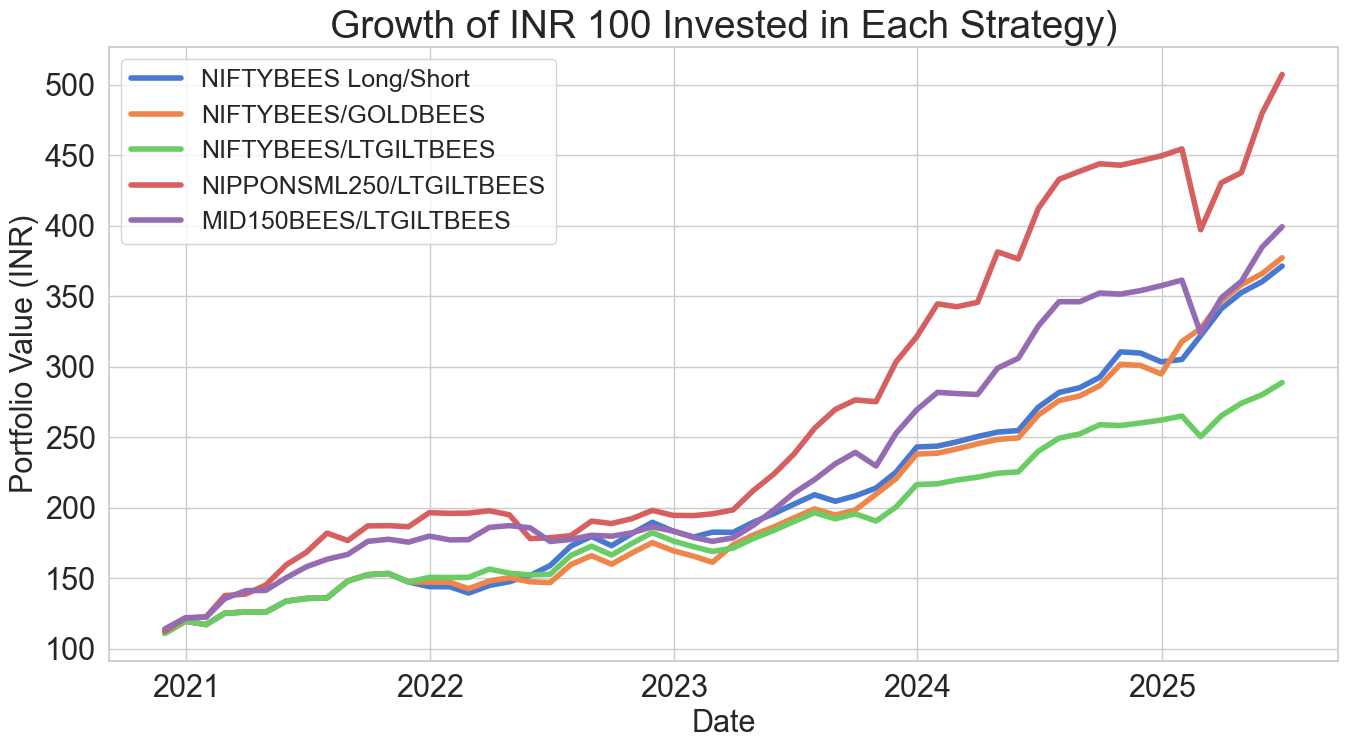

In [192]:
plt.figure(figsize=(14, 8))

# Merge all strategy returns on date index
merged_df = results_df[['Strategy_Return']].rename(columns={'Strategy_Return': 'NIFTYBEES Long/Short'})
merged_df = merged_df.merge(hybrid_results_df[['Strategy_Return']].rename(columns={'Strategy_Return': 'NIFTYBEES/GOLDBEES'}), left_index=True, right_index=True, how='inner')
merged_df = merged_df.merge(gilt_results_df[['Strategy_Return']].rename(columns={'Strategy_Return': 'NIFTYBEES/LTGILTBEES'}), left_index=True, right_index=True, how='inner')
merged_df = merged_df.merge(hdfc_results_df[['Strategy_Return']].rename(columns={'Strategy_Return': 'NIPPONSML250/LTGILTBEES'}), left_index=True, right_index=True, how='inner')
merged_df = merged_df.merge(mid_results_df[['Strategy_Return']].rename(columns={'Strategy_Return': 'MID150BEES/LTGILTBEES'}), left_index=True, right_index=True, how='inner')

merged_df = merged_df.dropna()

# Calculate cumulative returns for each strategy
cum_df = (1 + merged_df).cumprod() * 100

# Plot cumulative returns for each strategy using seaborn for improved aesthetics

plt.figure(figsize=(14, 8))
cum_df = (1 + merged_df).cumprod() * 100

sns.set(style="whitegrid", palette="muted", font_scale=2)  # Larger font
for col in cum_df.columns:
    sns.lineplot(x=cum_df.index, y=cum_df[col], label=col, linewidth=4)  # Thicker lines

plt.title("Growth of INR 100 Invested in Each Strategy)", fontsize=28)
plt.xlabel("Date", fontsize=22)
plt.ylabel("Portfolio Value (INR)", fontsize=22)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()